# Differential exprssion analysis

In [ ]:
library_load <- suppressMessages(
    
    suppressWarnings(
        
        list(
        
            # DEA 
            library(DESeq2), 
            library(IHW), # Independent Hypothesis Weighting
            library(edgeR), # For CPM 
            
            # Bioconductor tools
            library(rtracklayer), # readGFF, export
            library(Rsubread), # featureCounts
            
            # Data
            library(dplyr), 
            library(rtracklayer), 
            
            # Plotting 
            library(ggplot2), 
            library(patchwork), 
            library(ComplexHeatmap), 
            library(grid) # For gpar
            
        )
    )
)

In [ ]:
options(warn=-1)

In [ ]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO") # You need to adjust this path. I will help. 

In [ ]:
# Plotting Theme
source("plotting_global.R")
ggplot2::theme_set(theme_global_set(size_select=1)) # From project global source()

# Parameter 

In [ ]:
cache <- TRUE

In [ ]:
gft_file <- "/research/peer/fdeckert/reference/genome/GRCm39/gencode.vM33.annotation.gtf.gz"

# Create count matrix from BSF STAR output 

In [ ]:
star_bam <- list.files("/nobackup/peer/fdeckert/FD20200109SPLENO/data/BSA_0885_FACS_FD/", pattern=".bam$", full.names=TRUE, recursive=TRUE)

In [ ]:
if(!cache) {
    
    feature_count <- featureCounts(
    
        star_bam,

        # Annotation
        annot.ext=gft_file, 
        isGTFAnnotationFile=TRUE, 

        # Paired-end mode 
        isPairedEnd=FALSE, 

        # Feature type
        GTF.featureType="gene",

        # Strand specificity
        strandSpecific=1, 

        # read filtering
        ignoreDup=TRUE
        
    
    )
    
    saveRDS(feature_count, "data/bulkRNAseq/feature_count.rds")

} else {
    
    feature_count <- readRDS("data/bulkRNAseq/feature_count.rds")
    
}

# Import BSF DESeq2 object

In [ ]:
# Prepare meta data 
meta <- read.csv("/nobackup/peer/fdeckert/FD20200109SPLENO/data/BSA_0885_FACS_FD/BSA_0884_FACS.csv", row.names=2)
meta <- meta[grep("FD", rownames(meta), value=TRUE), ]
meta$sample_name <- rownames(meta)

In [ ]:
# Remove monocyte low input sample 
meta <- meta[meta$sample_name!="FD_80", ]

In [ ]:
# Prepare count matrix 
cnt <- feature_count[["counts"]]

In [ ]:
# Store full bam file names 
bam_files <- colnames(cnt)

In [ ]:
# Replace BAM file names with sample names 
colnames(cnt) <- gsub("_0|_00", "_", colnames(cnt))
colnames(cnt) <- gsub("star_sample_|_S.*", "", colnames(cnt), fixed=FALSE)

In [ ]:
# Add BAM path to meta 
meta <- dplyr::left_join(meta, data.frame(sample_name=colnames(cnt), bam_path=paste0("/nobackup/peer/fdeckert/FD20200109SPLENO/data/BSA_0885_FACS_FD/mm39_ERCC92/", gsub(".bam", "", basename(bam_files)), "/", bam_files)), by = join_by(sample_name))
rownames(meta) <- meta$sample_name

In [ ]:
meta <- meta[intersect(rownames(meta), colnames(cnt)), ]
cnt <- cnt[, intersect(rownames(meta), colnames(cnt))]
all(rownames(meta)==colnames(cnt))

In [ ]:
meta <- meta[, c("sample_name", "Cell.Type", "Disease", "Disease", "Genotype", "Material.Type", "bam_path")]
colnames(meta) <- c("sample_name", "celltype", "disease", "dpi", "genotype", "lib_protocol", "bam_path")

In [ ]:
meta <- dplyr::mutate(
    
    meta, celltype=recode(celltype, "Monocyte"="cMo", "preRPM"="PreRPM", "RPM"="RPM", "EB"="EB"), 
    disease=recode(disease, "Baseline"="Baseline", "CpG_D1"="CpG", "CpG_D3"="CpG", "CpG_D7"="CpG"), 
    dpi=recode(dpi, "Baseline"="D0", "CpG_D1"="D1", "CpG_D3"="D3", "CpG_D7"="D6"), 
    genotype=recode(genotype, "wt/wt"="IFNAR_fl", "cre/+"="IFNAR_fl_LysM_cre"), 
    lib_protocol=recode(lib_protocol, "RNA low input"="low_input", "RNA normal input >10ng"="normal_input")

)

## Set factor levels

In [ ]:
# Set factor levels 
meta$celltype <- factor(meta$celltype, levels=c("cMo", "PreRPM", "RPM", "EB"))
meta$disease <- factor(meta$disease, levels=c("Baseline", "CpG"))
meta$dpi <- factor(meta$dpi, levels=c("D0", "D1", "D3", "D6"))
meta$genotype <- factor(meta$genotype, levels=c("IFNAR_fl", "IFNAR_fl_LysM_cre"))
meta$lib_protocol <- factor(meta$lib_protocol, levels=c("low_input", "normal_input"))

## Check count matrix

In [ ]:
# Filter genes with 0 counts 
cnt <- cnt[rowSums(cnt)>0, ]

In [ ]:
# Filter out spike in 
cnt <- cnt[grepl("ENSMUSG", rownames(cnt)), ]

## Order data 

In [ ]:
# Reset order of samples in cnt and meta
cnt <- cnt[, intersect(colnames(cnt), rownames(meta))]
meta <- meta[intersect(colnames(cnt), rownames(meta)), ]

In [ ]:
all(rownames(meta)==colnames(cnt))

## Compute library size 

In [ ]:
# Get data frame with library size per sample 
library_size <- data.frame(sample_name=colnames(cnt), library_size=colSums(cnt))

# Use the sample_name column to combine meta data with library size. 
meta <- dplyr::left_join(meta, library_size, by="sample_name")

In [ ]:
# dplyr removes rownames so re-set
rownames(meta) <- meta$sample_name

# Convert from ENSEML ID to MGI Symbol 

In [ ]:
import_convert <- function(gtf_path=gft_file) {
    
    # Load reference gtf 
    gtf <- rtracklayer::import(gtf_path)
    gtf <- as.data.frame(gtf)
    # Subset data 
    convert <- gtf[, c("gene_id", "gene_name")] 
    # Rename columns 
    colnames(convert) <- c("ensembl_gene_id", "mgi_symbol")
    # Select unique entries 
    convert <- unique(convert)
    convert <- na.omit(convert)

    message(paste("Total number of ENSEMBL ID matched with MGI SYMBOL:", nrow(convert)))
    
    # Filter convert table for unique entries
    ensembl_gene_id_multiple <- table(convert$ensembl_gene_id)
    ensembl_gene_id_multiple <- ensembl_gene_id_multiple[ensembl_gene_id_multiple>1]
    convert <- convert[!convert$ensembl_gene_id %in% names(ensembl_gene_id_multiple), ]
    message(paste("Unique ENSEMBL ID:", nrow(convert)))

    mgi_symbol_multiple <- table(convert$mgi_symbol)
    mgi_symbol_multiple <- mgi_symbol_multiple[mgi_symbol_multiple>1]
    convert <- convert[!convert$mgi_symbol %in% names(mgi_symbol_multiple), ]
    message(paste("Unique MGI SYMBOL:", nrow(convert)))
    
    return(convert)
    
}

In [ ]:
convert <- import_convert()

In [ ]:
ensembl_to_mgi <- function(data, convert) {
     
    # Filter data and convert by shared ensemble_gene_id 
    rownames(convert) <- convert$ensembl_gene_id
    data <- data[rownames(data) %in% rownames(convert), ]
    convert <- convert[rownames(convert) %in% rownames(data), ]
    convert <- convert[rownames(data), ]

    # Convert ensemble_gene_id to mgi_symbol
    rownames(data) <- convert$mgi_symbol
    
    # Add full annotation 
    data$mgi_symbol <- convert$mgi_symbol
    data$ensembl_gene_id <- rownames(convert)
    
    return(data)
    
}

# Subset counts to enseble IDs present in the converter 

In [ ]:
message(paste("ENSEMBL ID from count data not fround in ensemble converter:", table(rownames(cnt) %in% rownames(convert))[1]))

In [ ]:
cnt <- cnt[rownames(cnt) %in% convert[, 1], ]

# Plot library size 

In [ ]:
# First order the samples by celltype and dpi. Then set the sample_name as factor leves. That way in the folloing plot the samples will be nicely ordered. 
meta <- dplyr::arrange(meta, celltype)
meta$sample_name <- factor(meta$sample_name, levels=meta$sample_name)

In [ ]:
options(repr.plot.width=25, repr.plot.height=5)

# Library sizes counts
ggplot(meta, aes(x=sample_name, y=library_size, fill=celltype)) + 
    geom_bar(stat="identity") +
    ggtitle("Library size") + xlab("Sample") + ylab("Library size [counts]") + 
    # scale_fill_manual(values=color$cell_type_main) +
    facet_grid(~dpi, scales="free_x", space="free") + 
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

In [ ]:
options(repr.plot.width=25, repr.plot.height=5)

# Library sizes log10(counts)
ggplot(meta, aes(x=sample_name, y=log10(library_size), fill=celltype)) + 
    geom_bar(stat="identity") +
    ggtitle("Library size") + xlab("Sample") + ylab("Library size [log10(counts)]") + 
    # scale_fill_manual(values=color$cell_type_main) +
    facet_grid(~dpi, scales="free_x", space="free") + 
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

## Gene count distribution 

In [ ]:
# For plotting we need to convert the counts from wide to long format (http://www.cookbook-r.com/Manipulating_data/Converting_data_between_wide_and_long_format/)
data <- reshape2::melt(cnt, varnames=c("ENSEMBL_ID", "sample_name"), value.name="counts")

# Combine with meta data 
data <- dplyr::left_join(data, meta, by="sample_name")

In [ ]:
# Again, set factor levels for plotting  
data <- dplyr::arrange(data, celltype)
data$sample_name <- factor(data$sample_name, levels=unique(data$sample_name)) # The sample names are now repeated and we need to use unique for the levels. 

In [ ]:
options(repr.plot.width=25, repr.plot.height=5)

ggplot(data, aes(x=sample_name, y=log2(counts), fill=celltype)) + 
    geom_boxplot() +
    ggtitle("Gene count distribution") + xlab("Sample") + ylab("Gene count [log2(counts)]") + 
    # scale_fill_manual(values=color$cell_type_main) + 
    facet_grid(~dpi, scales="free_x", space="free") + 
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

# Ensure order of data 

In [ ]:
# Reset order of samples in cnt and meta
cnt <- cnt[, intersect(colnames(cnt), rownames(meta))]
meta <- meta[intersect(colnames(cnt), rownames(meta)), ]

In [ ]:
all(rownames(meta)==colnames(cnt))

# Principal component analysis 

In [ ]:
pca_plot <- function(pca_data) {
    
    pca_plot_1 <- ggplot(pca_data, aes(PC1, PC2, color=celltype, fill=celltype, shape=genotype)) + 
        geom_point(size=5, stroke=1) + 
        ggtitle("PCA (Celltype)") + 
        xlab(paste0("PC1: ", round(100 * attr(pca_data, "percentVar"))[1],"% variance")) +
        ylab(paste0("PC2: ", round(100 * attr(pca_data, "percentVar"))[2],"% variance")) + 
        # scale_color_manual("Cell type", values=color$cell_type_main) +
        # scale_fill_manual("Cell type", values=color$cell_type_main) + 
        scale_shape_manual("Genotype", values=setNames(c(21, 24), c("IFNAR_fl", "IFNAR_fl_LysM_cre"))) + 
        theme(aspect.ratio=1, legend.position="right") + guides(fill=guide_legend(byrow=TRUE)) + guides(color=guide_legend(byrow=TRUE)) + guides(shape=guide_legend(byrow=TRUE))

    pca_plot_2 <- ggplot(pca_data, aes(PC1, PC2, color=dpi, fill=dpi, shape=genotype)) + 
        geom_point(size=5, stroke=1) + 
        ggtitle("PCA (DPI)") + 
        xlab(paste0("PC1: ", round(100 * attr(pca_data, "percentVar"))[1],"% variance")) +
        ylab(paste0("PC2: ", round(100 * attr(pca_data, "percentVar"))[2],"% variance")) + 
        scale_color_manual("DPI", values=color$dpi) +
        scale_fill_manual("DPI", values=color$dpi) + 
        scale_shape_manual("Genotype", values=setNames(c(21, 24), c("IFNAR_fl", "IFNAR_fl_LysM_cre"))) + 
        theme(aspect.ratio=1, legend.position="right") + guides(fill=guide_legend(byrow=TRUE)) + guides(color=guide_legend(byrow=TRUE)) + guides(shape=guide_legend(byrow=TRUE))

    pca_plot_3 <- ggplot(pca_data, aes(PC1, PC2, color=lib_protocol, fill=lib_protocol, shape=genotype)) + 
        geom_point(size=5, stroke=1) + 
        ggtitle("PCA (Library protocol)") + 
        xlab(paste0("PC1: ", round(100 * attr(pca_data, "percentVar"))[1],"% variance")) +
        ylab(paste0("PC2: ", round(100 * attr(pca_data, "percentVar"))[2],"% variance")) + 
        scale_color_manual("Protocol", values=c("low_input"="#f54260", "normal_input"="#4287f5")) +
        scale_fill_manual("Protocol", values=c("low_input"="#f54260", "normal_input"="#4287f5")) + 
        scale_shape_manual("Genotype", values=setNames(c(21, 24), c("IFNAR_fl", "IFNAR_fl_LysM_cre"))) + 
        theme(aspect.ratio=1, legend.position="right") + guides(fill=guide_legend(byrow=TRUE)) + guides(color=guide_legend(byrow=TRUE)) + guides(shape=guide_legend(byrow=TRUE))

    pca_plot_4 <- ggplot(pca_data, aes(PC1, PC2, color=library_size, fill=library_size, shape=genotype)) + 
        geom_point(size=5, stroke=1) + 
        ggtitle("PCA (Library size)") + 
        xlab(paste0("PC1: ", round(100 * attr(pca_data, "percentVar"))[1],"% variance")) +
        ylab(paste0("PC2: ", round(100 * attr(pca_data, "percentVar"))[2],"% variance")) + 
        scale_color_continuous("Library size") +
        scale_fill_continuous("Library size") + 
        scale_shape_manual("Genotype", values=setNames(c(21, 24), c("IFNAR_fl", "IFNAR_fl_LysM_cre"))) + 
        theme(aspect.ratio=1, legend.position="right") + guides(shape=guide_legend(byrow=TRUE))
    
    # Plot
    pca_plot_1 + pca_plot_2 + pca_plot_3 + pca_plot_4 + patchwork::plot_layout(ncol=4)
    
}

## All samples 

In [ ]:
dss <- DESeqDataSetFromMatrix(countData=cnt, colData=meta, design=~0+sample_name)
vst <- DESeq2::vst(dss, fitType="local")

In [ ]:
options(repr.plot.width=4*7.5, repr.plot.height=7.5)

pca_data <- DESeq2::plotPCA(vst, intgroup=colnames(meta), returnData=TRUE, ntop=500)
pca_plot(pca_data)

## Myeloid subset 

In [ ]:
dss <- DESeqDataSetFromMatrix(countData=cnt[, meta$celltype!="EB"], colData=meta[meta$celltype!="EB", ], design=~0+sample_name)
vst <- DESeq2::vst(dss, fitType="local")

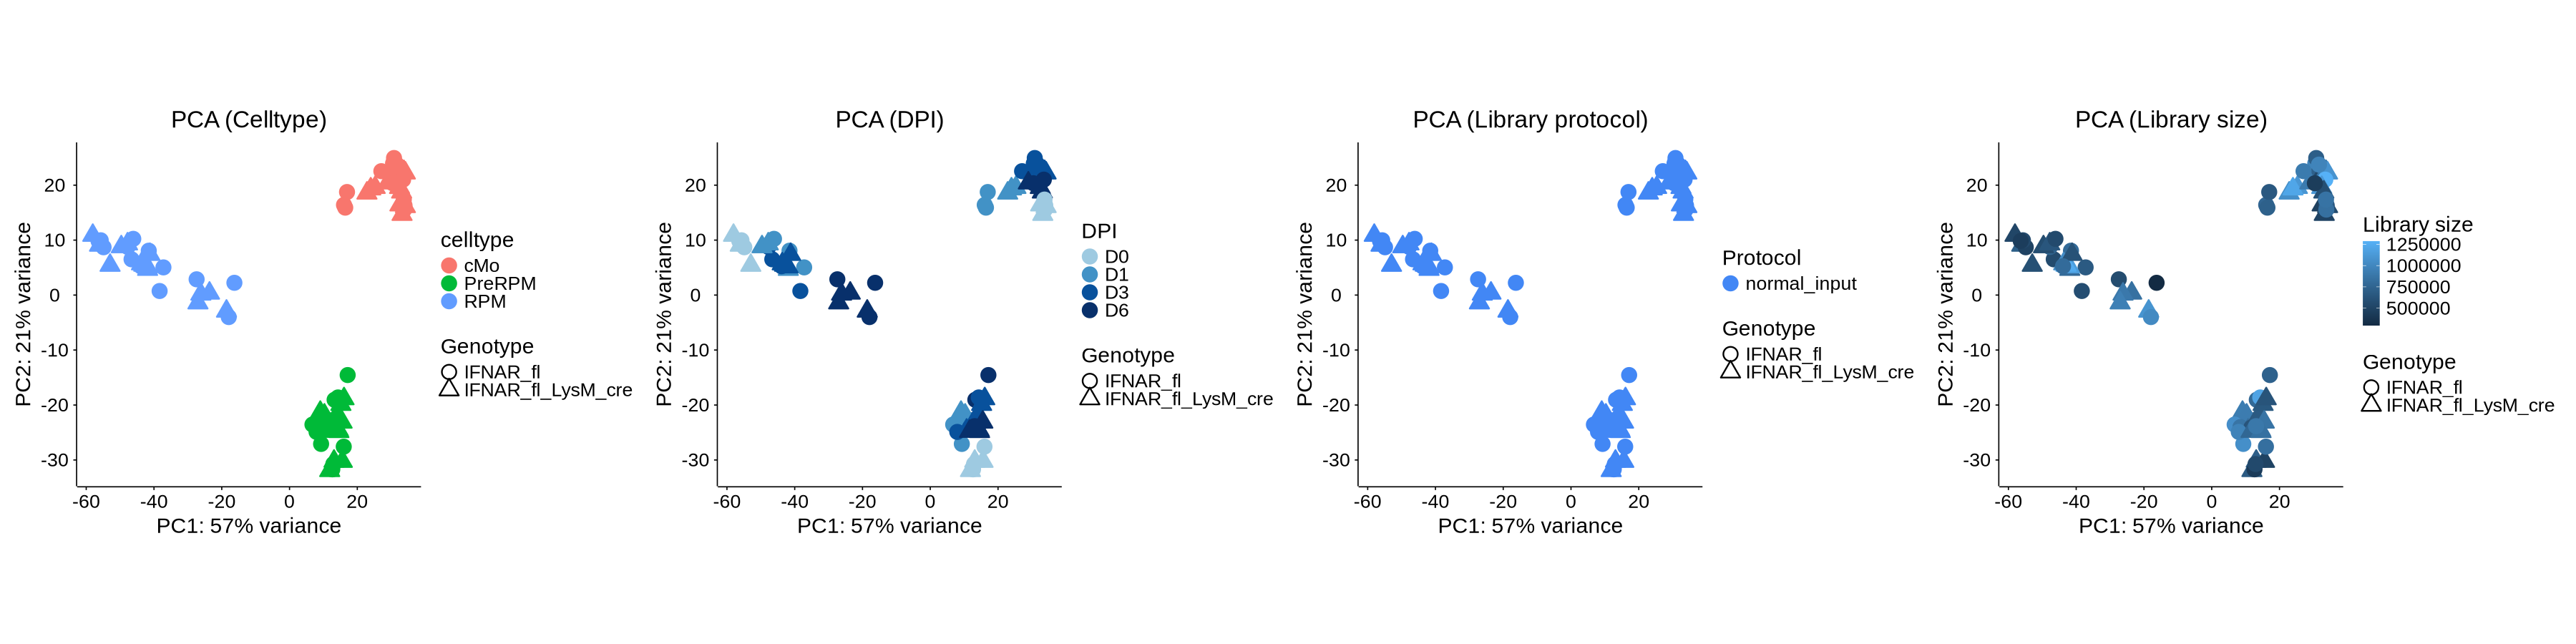

In [196]:
options(repr.plot.width=4*7.5, repr.plot.height=7.5)

pca_data <- DESeq2::plotPCA(vst, intgroup=colnames(meta), returnData=TRUE, ntop=500)
pca_plot(pca_data)

## Erythroblast subset 

In [197]:
dss <- DESeqDataSetFromMatrix(countData=cnt[, meta$celltype=="EB"], colData=meta[meta$celltype=="EB", ], design=~0+sample_name)
vst <- DESeq2::vst(dss, fitType="local")

factor levels were dropped which had no samples



using ntop=500 top features by variance



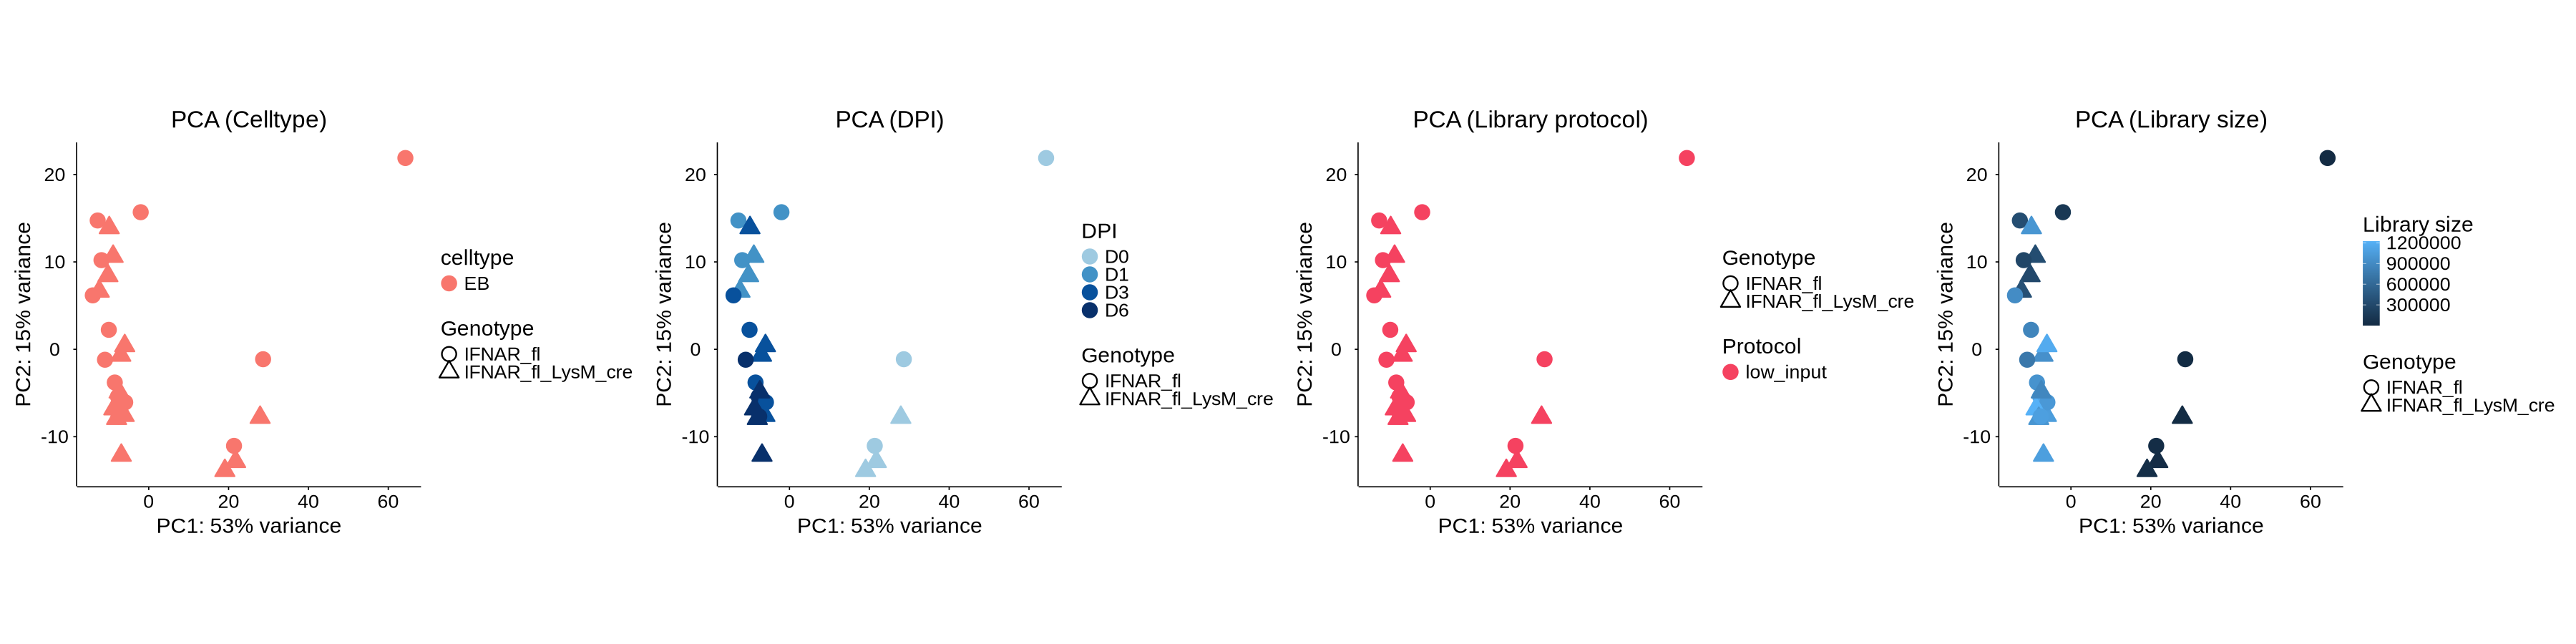

In [198]:
options(repr.plot.width=4*7.5, repr.plot.height=7.5)

pca_data <- DESeq2::plotPCA(vst, intgroup=colnames(meta), returnData=TRUE, ntop=500)
pca_plot(pca_data)

# Save objects 

In [199]:
saveRDS(meta, "data/bulkRNAseq/meta.rds")
saveRDS(ensembl_to_mgi(as.data.frame(cnt), convert=convert), "data/bulkRNAseq/cnt.rds")

In [200]:
write.csv(meta, "data/bulkRNAseq/meta.csv")
write.csv(ensembl_to_mgi(as.data.frame(cnt), convert=convert), "data/bulkRNAseq/cnt.csv")